## Materialization Correctness
To ensure the materialization code is working correctly, in this notebook, we create a medium size graph with several ml models and manually check the potential, recreation cost, and |pipelines| to compare with the computed values from the materialization code.

In [1]:
# numpy and pandas for data manipulation
import sys
import os
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import cPickle as pickle

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
root_data = ROOT_PACKAGE_DIRECTORY + '/data'


sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment
from experiment_graph.benchmark_helper import BenchmarkMetrics

DATABASE_PATH = root_data + '/experiment_graphs/home-credit-default-risk/materialization-test'
N_ESTIMATOR = 100

In [2]:
# Prepare the Data
# Create Execution Environment
ee = ExecutionEnvironment('dedup')

# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')
test = ee.load(root_data + '/openml/task_id=31/test.csv')

test_labels = test['class']
test = test.drop('class')

train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

creating a new root node
creating a new root node


In [3]:
# Random Forest 1 (n_estimator = 10)
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest10 = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest10.fit(train, train_labels)

# Execute
random_forest10.trained_node.data()

random_forest10.score(test, test_labels).data()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


{'accuracy': 0.79000000000000004}

In [4]:
# Random Forest 2 (n_estimator = 100)
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest100 = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest100.fit(train, train_labels)

# Execute
random_forest100.trained_node.data()

random_forest100.score(test, test_labels).data()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


{'accuracy': 0.76000000000000001}

In [5]:
# Logistic Regression
from experiment_graph.sklearn_helper.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

log_reg.score(test,
              test_labels).data()

{'accuracy': 0.69999999999999996}

In [6]:
# Gradient Boosted 1 (n_estimator = 60)
from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

model60 = LGBMClassifier(n_estimators=60, objective='binary',
                       class_weight='balanced', learning_rate=0.05,
                       reg_alpha=0.1, reg_lambda=0.1,
                       subsample=0.8, n_jobs=-1, random_state=50)

# Train the model
model60.fit(train, train_labels, custom_args={'eval_metric': 'accuracy',
                                            'verbose': 200})

# Make predictions
model60.score(test,test_labels).data()

{'accuracy': 0.81999999999999995}

In [7]:
# Gradient Boosted 2 (n_estimator = 100)
from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

model100 = LGBMClassifier(n_estimators=100, objective='binary',
                       class_weight='balanced', learning_rate=0.05,
                       reg_alpha=0.1, reg_lambda=0.1,
                       subsample=0.8, n_jobs=-1, random_state=50)

# Train the model
model100.fit(train, train_labels, custom_args={'eval_metric': 'accuracy',
                                            'verbose': 200})

# Make predictions
model100.score(test,test_labels).data()

{'accuracy': 0.81000000000000005}

In [8]:
ee.workload_graph.post_process()

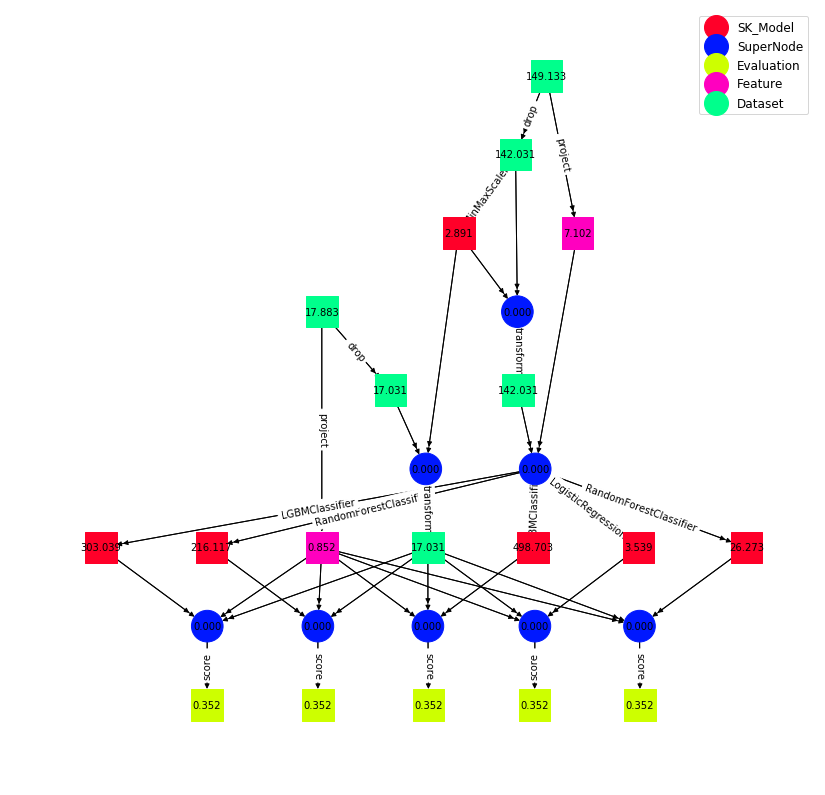

In [9]:
ee.workload_graph.plot_graph(plt, figsize=(14,14),labels_for_vertex=['size'], vertex_size=1000, vertex_font_size=10)

In [10]:
# from experiment_graph.materialization_algorithms.heuristics import compute_recreation_cost
# ee.update_history()

In [11]:
# graph = ee.history_graph.graph
# rec = compute_recreation_cost(graph, modify_graph=True)

In [12]:
# ee.history_graph.plot_graph(plt, figsize=(14,20), labels_for_vertex=['meta_freq','recreation_cost'], labels_for_edges=['execution_time'], vertex_size=1200)

In [13]:
from experiment_graph.materialization_algorithms.heuristics import compute_vertex_potential
ee.update_history()

history graph is empty, initializing a new one


In [14]:
graph = ee.history_graph.graph
pot = compute_vertex_potential(graph)

Evaluation
SuperNode
SK_Model
Evaluation
SuperNode
SK_Model
Evaluation
SuperNode
SK_Model
Evaluation
SuperNode
SK_Model
Evaluation
SuperNode
SK_Model
SuperNode
Feature
Dataset
SuperNode
Dataset
SuperNode
SK_Model
Dataset
Dataset
Feature
Dataset
Dataset


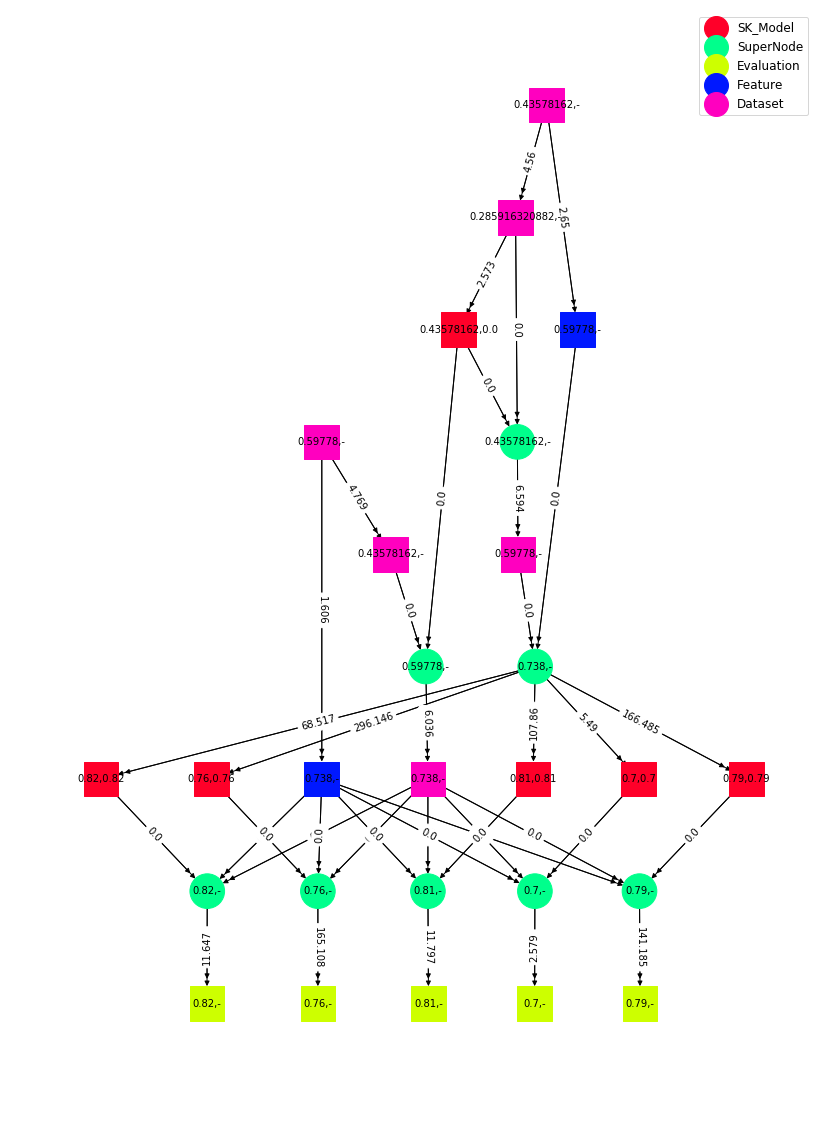

In [15]:
ee.history_graph.plot_graph(plt, figsize=(14,20), labels_for_vertex=['potential','score'], labels_for_edges=['execution_time'], vertex_size=1200)

In [16]:
print graph.out_degree('/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter/data/openml/task_id=31/test.csv')

2
